In [1]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from torch import nn as nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.distributions import Categorical

In [2]:
env = gym.make('CartPole-v1')

In [3]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

In [4]:
class ActorCritic(nn.Module):
    def __init__(self,input_dim,hidden,output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim,hidden)
        self.relu = nn.ReLU()
        self.logits = nn.Linear(hidden,output_dim)
        self.value = nn.Linear(hidden,1)
        
    def forward(self,state):
        
        x = self.fc1(state)
        x = self.relu(x)
        logits = self.logits(x)
        value = self.value(x)
        return logits,value
        
    
    def predict(self,state):
        logits,_ = self.forward(state)
        pi = Categorical(logits = logits)
        a = pi.sample()
        return a.item()

In [14]:
gamma = 1

In [15]:
model = ActorCritic(input_dim,64,output_dim)

In [16]:
optimizer = Adam(model.parameters(),lr = 0.001)
loss_fn = nn.MSELoss()

In [17]:
Episodes = 1000
beta = 0
zeta = 0

In [18]:
all_rewards = []
for episode in range(Episodes):
    done = False
    
    s = env.reset()
    
    logp = []
    states = []
    actions = []
    rewards = []
    s_prime = []
    
    while not done:
        states.append(s)
        logits,v = model(torch.FloatTensor(s))
        pi = Categorical(logits = logits)
        action = pi.sample()
        log_prob = pi.log_prob(action)
        action = action.item()
        
        s_prime,reward,done,_ = env.step(action)
        logp.append(log_prob)
        rewards.append(reward)
        
        s = s_prime
        #if episode % 100 == 0:
        #    env.render()
    
    all_rewards.append(np.sum(rewards))
    if episode % 100 == 0:

        print(f'Episode {episode} Score: {np.sum(rewards)}')
        
    discounted_rewards = []        
    for t in range(len(rewards)):
        G_t = 0
        pw = 0
        
        for r in rewards[t:]:
            G_t = G_t + gamma**pw * r
            pw += 1
            
        discounted_rewards.append(G_t) 
        
    td_deltas = []
    for t in range(len(rewards)):
#             _,v_prime = network(torch.FloatTensor(episode_states[t+1]))
            _,v = model(torch.FloatTensor(states[t]))

    
            td_deltas.append(discounted_rewards[t] - v)
        
    discounted_rewards = torch.FloatTensor(discounted_rewards)
    td_deltas = torch.FloatTensor(td_deltas)
    
    loss = - torch.stack(logp)@td_deltas
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
        
        

Episode 0 Score: 16.0
Episode 100 Score: 45.0
Episode 200 Score: 82.0
Episode 300 Score: 116.0
Episode 400 Score: 113.0
Episode 500 Score: 500.0
Episode 600 Score: 458.0
Episode 700 Score: 418.0
Episode 800 Score: 500.0
Episode 900 Score: 500.0


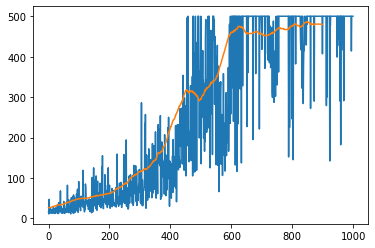

In [19]:
plt.plot(all_rewards);
plt.plot([np.mean(all_rewards[i:i+100]) for i in range(900)]);